**Leonardo Rodriguez**

# Scene classification

The dataset comes from kaggle:

https://www.kaggle.com/nitishabharathi/scene-classification


The goal is to create some predictive models that can identify scenes from given images. The classes in the dataset are:

* Buildings
* Forests
* Mountains
* Glacier
* Street
* Sea

## Results summary

The process involved some initial research on how machine vision and convolutional neural networks work, as well as some trial and error in the model building process to try different layers, optimizers, learning rates and even the data augmentation techniques used. I have left some comments mentioning a few of the places where I reached a better result by changing the approach from the one I started with. 

After obtaining the data from the source and organizing it in folders according to their category, the first step was to normalize and augment the data. This was done by using Kera´s ImageDataGenerator, where the pixel values were normalized to valies ranging between 0 and 1 and a few augmentations were given, such that we could take better advantage of the data. For example, showing the same image with slight variations such as rotations, vertical and horizontal flips, among others. One thing I found, at least for this given dataset, was that brightness augmentations did not give me good results. This is likely due to problems cause by some black or white images in the dataset. ImageDataGenerators were used for train, test and validation data.

In this project, I tried three different methods to reach a predictive model. I created a model from scratch to learn the basics of the convolutional neural network models and followed it up by trying transfer learning and fine tuning techniques to see their differences when using an existing model.

The following are the results obtained from the different models:

* **Model from scratch**

I used a simple model to play around with the different layers, it consists of a sequential model where I add a few layers one after the other. The model seen below has a couple of convolutional "blocks" composed of convolutional layers, max pooling layer, to map the most present feature on each patch of a feature map and a dropout layer to turn off random neurons to prevent over fitting. Finally, a fully connected layer to make the classifications.

Additionally, checkpoints were used to save the model weights as it progressed, as well as early stopping to prevent over training. 

This model can surely be improved, but for the purposes of this project, it achieved a reasonable result (67.86%) considering it was made from scratch with a very simple architecture.

* **Transfer learning model**

To go a bit further and hopefully improve the prediction capabilities obtained from the model I created from scratch, I attempted to use transfer learning from a pre-trained model. This technique (Feature Extraction) allows us to take a model that someone else has already trained, probably with a lot more data than what was provided in the kaggle exercise. The idea is to make use of the early set of layers of the model which are generic enough, so we can take advantage of those characteristics and finish training from scratch our classifier. 

This can be done by taking the model without the fully connected layer and "freezing" the layers we do not wish to train, to then finally "append" to our sequential model the last few layers we do want to train. 

As can be expected, this model gave a much better result (83.06%) without massive amounts of data or training time.

* **Fine tuning model**

As the name implies, fine tuning means to make more detailed adjustments to the final layers of the model in addition to the fully connected layer. Since the features learned by the model become more concrete to the domain of the problem in the later layers, we can take advantage of that and utilize the more general info extracted by earlier layers but then train the final ones for our problem at hand. In this case, for the pre-trained model that was used, this consisted on re-training the last block of layers and then adding our own fully connected layer on top. In this case, I used a learning rate of 1e-4 to make smaller adjustments and not damage previous progress made on the pre-trained model. 

As expected, this model gave the best result (88.49%).


In conclusion, if you don't have very large amounts of data, you can take advantage of previously trained models as long as you are mindful of the various techniques that can be used to repurpose its most basic layers and use them to re-train the more finer details to better fit the problem at hand. 

In [ ]:
import os
import shutil
import gc
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
from numpy import expand_dims
import random
import time
from IPython.display import clear_output
from IPython.utils import io
from datetime import datetime
from google.colab import drive
# scikit learn modules
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
# For model building and training
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
# Transfer learning
from tensorflow.keras.applications import VGG16

## Utility functions

In [ ]:
def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results, global_acc

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        
        #Gotta decode the prediction scores
        # decoded_pred = tf.math.argmax(y_preds[idx])
        # pred_idx = tf.keras.backend.eval(decoded_pred)
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        # ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
        #              color=("green" if pred_idx == true_idx else "red"))
        # TODO: Fix folder names to be tag name and use above line
        ax.set_title("{}\n({})".format(TAGS[pred_idx], TAGS[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

In [ ]:
def split_dataset(all_images_path,labeled_data,data_type,labeled_data_path = "labeled_data"):
  "Takes in a path and a dataframe with all images and splits them into multiple folders"
  root_path = os.path.join(labeled_data_path,data_type)
  # Make labeled data folder
  os.makedirs(labeled_data_path, exist_ok=True)
  # Keep track of quantities
  count = 0
  category_ammounts = {
      0:count,
      1:count,
      2:count,
      3:count,
      4:count,
      5:count
  }
  for img_name, category in labeled_data.itertuples(index=False):
      category_ammounts[category] += 1
      # Make a directory for the given category
      os.makedirs(f"{root_path}/{category}", exist_ok=True)

      # Move images into respective folder
      origin_path = os.path.join(all_images_path, img_name)
      destination_path = os.path.join(root_path , str(category), img_name)
      try:
        shutil.move(origin_path,destination_path)
      except FileNotFoundError as e:
        print(e)

  print(f"Completed moving all {data_type} images to their respective category folders")
  print(category_ammounts)
  return category_ammounts, root_path

## Data preparation

In [ ]:
DATA_PATH = "./dataset/"
IMAGES_PATH = os.path.join(DATA_PATH,"train-scene classification","train")
IMG_SIZE = 150
MODELS_PATH = "drive/MyDrive/Colab Notebooks/scene_classification"
TAGS = {
      0:"Buildings",
      1:"Forests",
      2:"Glacier",
      3:"Mountains",
      4:"Sea",
      5:"Street",
  }

In [ ]:
# Mount the drive for google colab
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check if there's a GPU active, if not, make sure to enable it with:
# edit -> notebook settings
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Downloading dataset

In [ ]:
# Download dataset from kaggle (first upload kaggle credentials)
input("Please upload kaggle credentials before proceding, then press any key")
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download nitishabharathi/scene-classification

Please upload kaggle credentials before proceding, then press any key
 96% 347M/361M [00:03<00:00, 111MB/s] 
100% 361M/361M [00:03<00:00, 112MB/s]


In [ ]:
# unzip dataset
if os.path.exists(DATA_PATH)==False:
  !mkdir "$DATA_PATH"
  with io.capture_output() as captured:
    !unzip scene-classification.zip -d "$DATA_PATH" 
  print("dataset ready")

dataset ready


In [ ]:
!rm scene-classification.zip

### Separating data into folders for each category

In [ ]:
labeled_data_path = os.path.join(DATA_PATH,"train-scene classification","train.csv")
labeled_data_df = pd.read_csv(labeled_data_path)
labeled_data_df.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [ ]:
sorted(labeled_data_df["label"].unique())

[0, 1, 2, 3, 4, 5]

In [ ]:
type(labeled_data_df["label"].unique()[0])

numpy.int64

In [ ]:
# NOTE: To define category ammount dict dynamically on split_dataset. 
cat_amount = {}
count = 0
for cat in sorted(labeled_data_df["label"].unique()):
  cat_amount[cat] = count
cat_amount

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}

In [ ]:
# do a train-test split with 20% data for test
train_df,test_df = train_test_split(labeled_data_df,
                              test_size=0.2,random_state=117)
# Need to do another train-test split so from the 80% for train, 25% of it goes 
# to validation (so 20% of total because 0.25*0.8=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=117)

In [ ]:
print(f"train size: {len(train_df)} \ntest size: {len(test_df)} \nval_size: {len(val_df)}")

train size: 10220 
test size: 3407 
val_size: 3407


In [ ]:
# Let's split images into folders according to their category

# Split train data in categories
train_catagory_ammounts, train_labeled_data_path = split_dataset(IMAGES_PATH,
                                                                 train_df,"train")
# Split test data in categories
test_catagory_ammounts, test_labeled_data_path = split_dataset(IMAGES_PATH,
                                                               test_df,"test")
# Split val dataset in categories
val_category_ammounts, val_labeled_data_path = split_dataset(IMAGES_PATH,
                                                             val_df, "val")

Completed moving all train images to their respective category folders
{0: 1575, 1: 1655, 2: 1775, 3: 1798, 4: 1658, 5: 1759}
Completed moving all test images to their respective category folders
{0: 509, 1: 563, 2: 597, 3: 611, 4: 551, 5: 576}
Completed moving all val images to their respective category folders
{0: 544, 1: 527, 2: 585, 3: 628, 4: 575, 5: 548}


In [ ]:
# Get the class subset
class_integers = np.array(sorted(os.listdir(train_labeled_data_path)))

In [ ]:
# Use one hot encoding for class_subset
enc = OneHotEncoder(sparse=False)
class_subset = enc.fit_transform(class_integers.reshape(-1, 1))

In [ ]:
class_subset

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

## Data augmentation

In [ ]:
# Check the paths for labeled data
print(train_labeled_data_path)
print(test_labeled_data_path)
print(val_labeled_data_path)

labeled_data/train
labeled_data/test
labeled_data/val


In [ ]:
# ImageDataGenerator 
"""
NOTES: Had to remove brightness as a varible, probably because some images are 
black and white and it doesn't behave well. Also could not get the validation 
split working properly, so it is done manually beforehand.
"""
train_generator = ImageDataGenerator(
                             rescale=1./255,              # Normalize pixel values between 1-0
                             rotation_range=20,           # Random rotation at 40 degrees
                             width_shift_range=0.2,       # Shift on width
                             height_shift_range=0.2,      # Shift on height
                             shear_range=0.2,             # Cut image
                             zoom_range=0.2,              # Zoom change
                             horizontal_flip=True,        # Flim images horizontally
                            #  brightness_range=[0.4,1.5],  # Alter brightness
                             fill_mode="nearest",         # How to fill missing data
                            #  validation_split=0.15,       # 15% of data for validation at end of epoch
                             )

validation_generator = ImageDataGenerator(rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255)

# Create the directory flow from the generator
BATCH_SIZE = 32

traingen = train_generator.flow_from_directory(f"{train_labeled_data_path}/",
                                               target_size=(IMG_SIZE, IMG_SIZE),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                              #  classes=class_subset,
                                               shuffle=True,
                                               seed=42)

validgen = validation_generator.flow_from_directory(f"{val_labeled_data_path}/",
                                               target_size=(IMG_SIZE, IMG_SIZE),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                              #  classes=class_subset,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(f"{test_labeled_data_path}/",
                                               target_size=(IMG_SIZE, IMG_SIZE),
                                               batch_size=1,
                                               class_mode=None,
                                              #  classes=class_subset,
                                               shuffle=False,
                                               seed=42)

Found 10220 images belonging to 6 classes.
Found 3407 images belonging to 6 classes.
Found 3407 images belonging to 6 classes.


## Creating Model - from scratch

In [ ]:
# Prepare model
nClasses = len(class_subset)
INIT_LR = 1e-3
"""For this project I tried a couple of optimizers, but I found
SGD to be more effective than Adam."""
# optimizer = tf.keras.optimizers.Adam(learning_rate=INIT_LR)
optimizer = tf.keras.optimizers.SGD(learning_rate=INIT_LR, name="SGD") 

scene_model = Sequential()
scene_model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',padding='same',input_shape=(IMG_SIZE, IMG_SIZE, 3)))
scene_model.add(MaxPooling2D((2, 2),padding='same'))
scene_model.add(Dropout(0.3))

# My test with an additional convolutional block made some improvements
scene_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding='same',input_shape=(IMG_SIZE, IMG_SIZE, 3)))
scene_model.add(MaxPooling2D((2, 2),padding='same'))
scene_model.add(Dropout(0.3))

scene_model.add(Flatten())
scene_model.add(Dense(512, activation='relu'))
scene_model.add(Dense(128, activation='relu'))
scene_model.add(Dense(32, activation='relu'))
scene_model.add(Dropout(0.3)) 
scene_model.add(Dense(nClasses, activation='softmax')) 
 
scene_model.summary()
 
scene_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.categorical_crossentropy,
                    metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 38, 38, 32)        0

In [ ]:
%%time

steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE
n_epochs = 100

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# Actual fitting of the model
history = scene_model.fit(traingen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer],
                    verbose=1)

Epoch 1/100
319/319 [==============================] - ETA: 0s - loss: 1.7541 - accuracy: 0.2474
Epoch 00001: val_loss improved from inf to 1.67368, saving model to img_model.weights.best.hdf5
319/319 [==============================] - 84s 224ms/step - loss: 1.7541 - accuracy: 0.2474 - val_loss: 1.6737 - val_accuracy: 0.4254
Epoch 2/100
319/319 [==============================] - ETA: 0s - loss: 1.6064 - accuracy: 0.3690
Epoch 00002: val_loss improved from 1.67368 to 1.47966, saving model to img_model.weights.best.hdf5
319/319 [==============================] - 70s 221ms/step - loss: 1.6064 - accuracy: 0.3690 - val_loss: 1.4797 - val_accuracy: 0.4649
Epoch 3/100
319/319 [==============================] - ETA: 0s - loss: 1.4850 - accuracy: 0.4125
Epoch 00003: val_loss improved from 1.47966 to 1.37814, saving model to img_model.weights.best.hdf5
319/319 [==============================] - 70s 219ms/step - loss: 1.4850 - accuracy: 0.4125 - val_loss: 1.3781 - val_accuracy: 0.4767
Epoch 4/100

## Evaluating network - Model from scratch

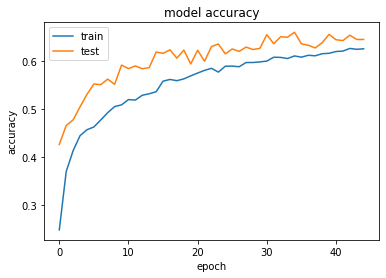

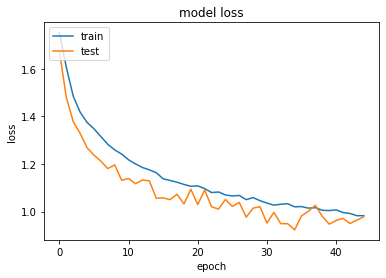

In [ ]:
# Plot the history of the model 
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy - Model from scratch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss - Model from scratch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Predict gives scores of the regression, it needs to be turned into the actual class
predicted_classes = scene_model.predict(testgen).argmax(axis=-1)

class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

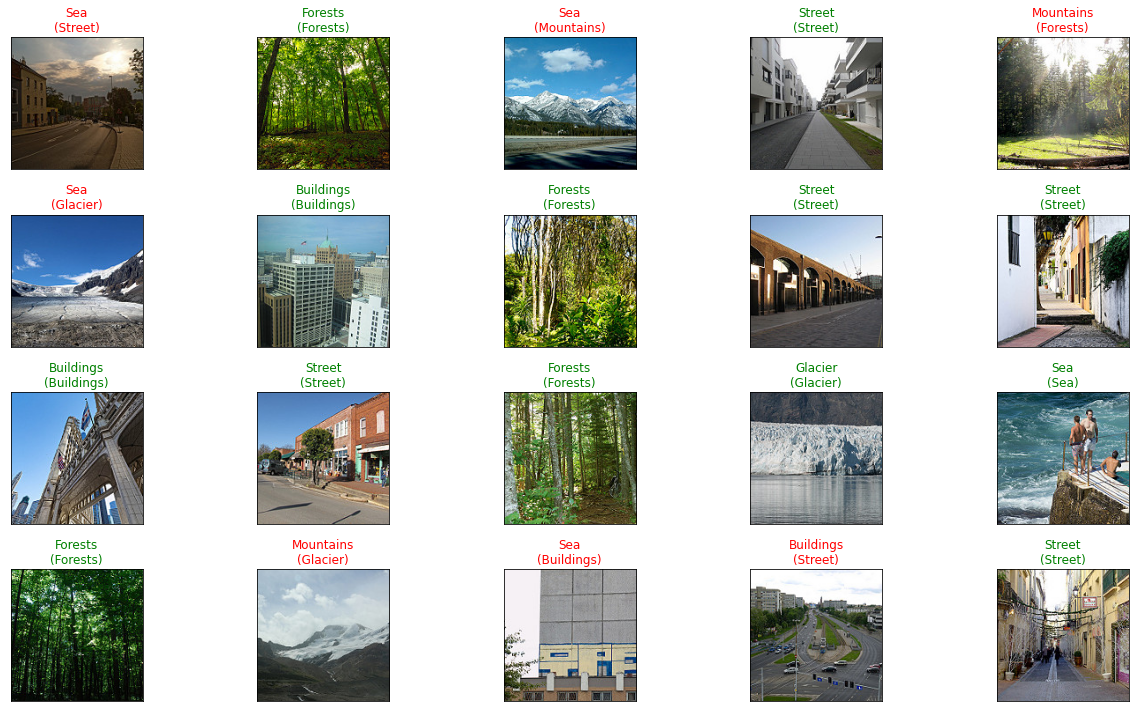

In [ ]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

In [ ]:
results, global_acc = display_results(true_classes, predicted_classes, class_indices.values())
results

Overall Categorical Accuracy: 67.86%


,Precision,Recall,F-Score,Support
1,0.732337,0.957371,0.829869,563.0
5,0.778000,0.675347,0.723048,576.0
3,0.671902,0.630115,0.650338,611.0
4,0.585781,0.687840,0.632721,551.0
2,0.745921,0.536013,0.623782,597.0
0,0.574713,0.589391,0.581959,509.0


In [ ]:
# To get global accuracy to 2 decimals
f"{global_acc*100:.2f}"

'67.86'

### Save best model to drive

In [ ]:
!ls "drive/MyDrive/Colab Notebooks/scene_classification"

In [ ]:
# Save best model to Google Drive
accuracy_str = f"_acc_{global_acc*100:.2f}".replace(".","_")
model_name = str(datetime.now().strftime("%Y-%m-%d_%H-%M-%S")) + accuracy_str + ".h5"
model_path = MODELS_PATH + "/" + model_name
scene_model.save(model_path)

### Load best model 

In [ ]:
!ls "$MODELS_PATH"

In [ ]:
# Load the model
model_filename = "2021-10-21_20-22-08_acc_68_30.h5"
scene_model = tf.keras.models.load_model(MODELS_PATH + "/" + model_filename)

# Show the model architecture
scene_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 180000)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                5760032   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0

## Transfer learning

In [ ]:
"""
Take pre-trained model, specify the input_shape, as default for VGG16 model is 
224x224, which is not the same as the input images from this kaggle exercise. 
Let's also not "include_top" which are the 3 fully-connected layers at the top 
of the network, because we want to train our own. 
We also get the the weights from imagenet pre-training.
"""
pre_trained_model = VGG16(input_shape=(IMG_SIZE,IMG_SIZE,3),
                          include_top = False,
                          weights = 'imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
"""
We don't want to change the weights on the pre-trained layers from the 
convolutional base, so we have to freeze those layers
"""
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
"""
We can also take models as layers, so we can add the pre-trained model to a 
sequential model and add layers to it. 
"""
nClasses = len(class_subset)

"""
In my testing, I found Flatten to drop the shape too sharply, so I instead
changed it to GlobalAveragePooling2D, which worked a lot better.
Also played around with dropout to see the effect of removing neurons randomly.
"""
modelFE = tf.keras.models.Sequential([
                                      pre_trained_model,
                                      # Flatten(),
                                      GlobalAveragePooling2D(), 
                                      Dense(256, activation='relu'),
                                      Dropout(0.3),
                                      Dense(nClasses, activation='softmax')
])

In [ ]:
modelFE.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 14,847,558
Trainable params: 132,870
Non-trainable params: 14,714,688
____________________________________

In [ ]:
INIT_LR = 1e-3
"""As mentioned earlier, I found better results with SGD optimizer"""
# optimizer = tf.keras.optimizers.Adam(learning_rate=INIT_LR)
optimizer = tf.keras.optimizers.SGD(learning_rate=INIT_LR, name="SGD")

modelFE.compile(optimizer=optimizer,
                loss=tf.keras.losses.categorical_crossentropy,
                metrics=["accuracy"])

In [ ]:
%%time

steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE
n_epochs = 100

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# Actual fitting of the model
historyFE = modelFE.fit(traingen,
                      epochs=n_epochs, 
                      steps_per_epoch=steps_per_epoch,
                      validation_data=validgen,
                      validation_steps=val_steps,
                      callbacks=[early_stop, checkpointer],
                      verbose=1)

Epoch 1/100
319/319 [==============================] - ETA: 0s - loss: 1.7621 - accuracy: 0.2421
Epoch 00001: val_loss improved from inf to 1.62032, saving model to img_model.weights.best.hdf5
319/319 [==============================] - 98s 288ms/step - loss: 1.7621 - accuracy: 0.2421 - val_loss: 1.6203 - val_accuracy: 0.4959
Epoch 2/100
319/319 [==============================] - ETA: 0s - loss: 1.6135 - accuracy: 0.3629
Epoch 00002: val_loss improved from 1.62032 to 1.50403, saving model to img_model.weights.best.hdf5
319/319 [==============================] - 90s 282ms/step - loss: 1.6135 - accuracy: 0.3629 - val_loss: 1.5040 - val_accuracy: 0.6147
Epoch 3/100
319/319 [==============================] - ETA: 0s - loss: 1.5101 - accuracy: 0.4541
Epoch 00003: val_loss improved from 1.50403 to 1.40788, saving model to img_model.weights.best.hdf5
319/319 [==============================] - 90s 280ms/step - loss: 1.5101 - accuracy: 0.4541 - val_loss: 1.4079 - val_accuracy: 0.6675
Epoch 4/100

## Evaluating network - Transfer Learning

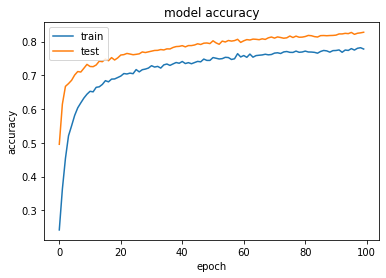

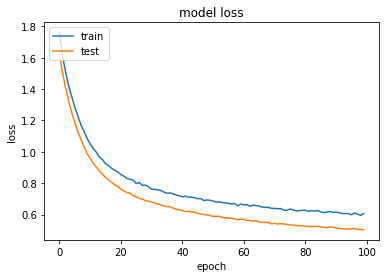

In [ ]:
# Plot the history of the model 
# summarize history for accuracy
plt.plot(historyFE.history['accuracy'])
plt.plot(historyFE.history['val_accuracy'])
plt.title('model accuracy - Transfer Learning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss 
plt.plot(historyFE.history['loss'])
plt.plot(historyFE.history['val_loss'])
plt.title('model loss - Transfer Learning')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Predict gives scores of the regression, it needs to be turned into the actual class
predicted_classes = modelFE.predict(testgen).argmax(axis=-1)

class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

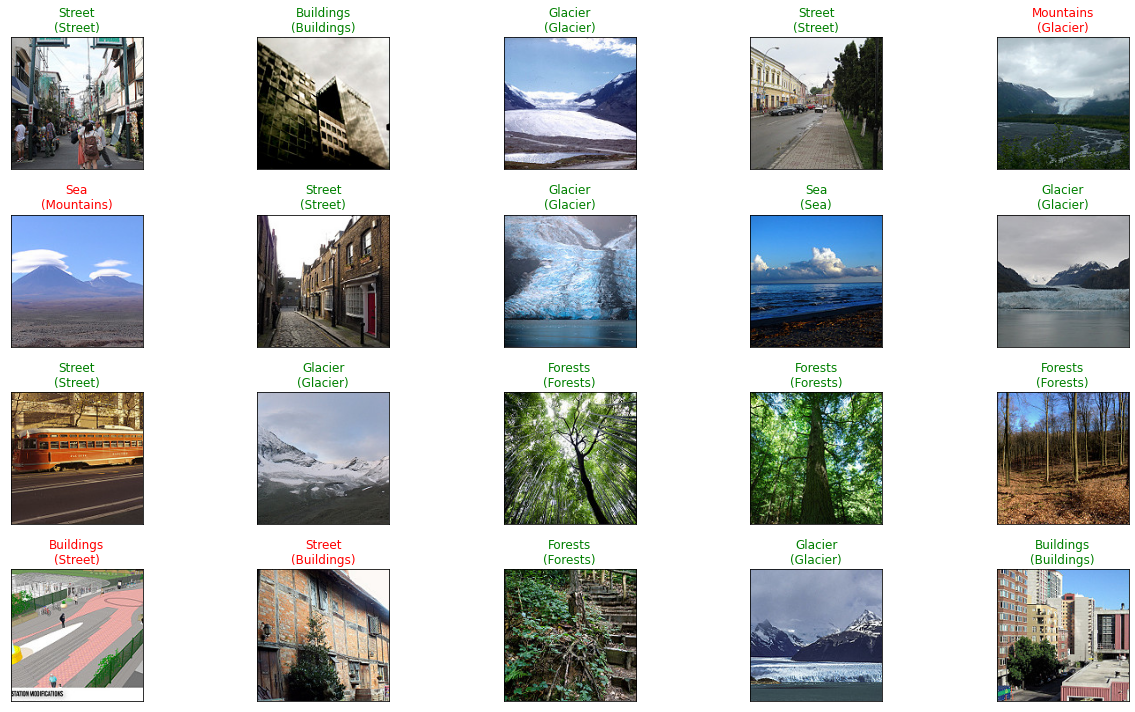

In [ ]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

In [ ]:
results, global_acc = display_results(true_classes, predicted_classes, class_indices.values())
results

Overall Categorical Accuracy: 83.06%


,Precision,Recall,F-Score,Support
1,0.955830,0.960924,0.958370,563.0
5,0.870674,0.829861,0.849778,576.0
0,0.823748,0.872299,0.847328,509.0
4,0.882600,0.764065,0.819066,551.0
2,0.723781,0.820771,0.769231,597.0
3,0.761269,0.746318,0.753719,611.0


### Save transfer learning model

In [ ]:
!ls "drive/MyDrive/Colab Notebooks/scene_classification"

In [ ]:
# Model name when saving it
f"_acc_{global_acc*100:.2f}_TL".replace(".","_")

'_acc_83_06_TL'

In [ ]:
# Save best model to Google Drive
accuracy_str = f"_acc_{global_acc*100:.2f}_TL ".replace(".","_")
model_name = str(datetime.now().strftime("%Y-%m-%d_%H-%M-%S")) + accuracy_str + ".h5"
model_path = MODELS_PATH + "/" + model_name
modelFE.save(model_path)

## Fine tuning

In [ ]:
"""
In the transfer learning section, I took a pre-trained model and took all layers
except the top 3 (which I wanted to replace with my own) and froze them. So 
everything stayed the same, except the layers that were added.

For fine tuning, we are going to do something slightly different, we will take
the model without the top layers like last time. But this time we will train
the last block of the pre-trained model (block_5)
"""
pre_trained_model = VGG16(input_shape=(IMG_SIZE,IMG_SIZE,3),
                          include_top = False,
                          weights = 'imagenet')

pre_trained_model.trainable = True

set_trainable = False
for layer in pre_trained_model.layers:
  if "block5" in layer.name:
    set_trainable = True
  # Separate the trainable layers and non-trainable ones
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Now we can add the layers we want to add at the end to replace the top layers
# we removed

nClasses = len(class_subset)

"""
Once again, Flatten did not give me good results, so I ended up choosing
GlobalAveragePooling2D
"""
modelFT = Sequential([
                      pre_trained_model,
                      #Flatten(),
                      GlobalAveragePooling2D(),
                      Dense(256,activation='relu'),
                      Dense(128,activation='relu'),
                      Dropout(0.4),
                      Dense(nClasses, activation='softmax')
])

In [ ]:
modelFT.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                      

In [ ]:
# Compile and train our network
INIT_LR = 1e-4  # I opted for a smaller learning rate for the fine tuning model
"""
As in previous models, I opted for SGD over Adam because it worked better in 
my testing.
"""
# optimizer = tf.keras.optimizers.Adam(learning_rate=INIT_LR) # first optimizer tested
optimizer = tf.keras.optimizers.SGD(learning_rate=INIT_LR, name="SGD")

modelFT.compile(optimizer=optimizer,
                loss=tf.keras.losses.categorical_crossentropy,
                metrics=["accuracy"])

In [ ]:
%%time

steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE
n_epochs = 100

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# Actual fitting of the model
historyFT = modelFT.fit(traingen,
                        epochs=n_epochs, 
                        steps_per_epoch=steps_per_epoch,
                        validation_data=validgen,
                        validation_steps=val_steps,
                        callbacks=[early_stop, checkpointer],
                        verbose=1)

Epoch 1/100
319/319 [==============================] - ETA: 0s - loss: 1.8329 - accuracy: 0.2055
Epoch 00001: val_loss improved from inf to 1.73705, saving model to img_model.weights.best.hdf5
319/319 [==============================] - 115s 313ms/step - loss: 1.8329 - accuracy: 0.2055 - val_loss: 1.7371 - val_accuracy: 0.1940
Epoch 2/100
319/319 [==============================] - ETA: 0s - loss: 1.7448 - accuracy: 0.2409
Epoch 00002: val_loss improved from 1.73705 to 1.66352, saving model to img_model.weights.best.hdf5
319/319 [==============================] - 97s 303ms/step - loss: 1.7448 - accuracy: 0.2409 - val_loss: 1.6635 - val_accuracy: 0.2936
Epoch 3/100
319/319 [==============================] - ETA: 0s - loss: 1.6667 - accuracy: 0.3011
Epoch 00003: val_loss improved from 1.66352 to 1.59297, saving model to img_model.weights.best.hdf5
319/319 [==============================] - 97s 304ms/step - loss: 1.6667 - accuracy: 0.3011 - val_loss: 1.5930 - val_accuracy: 0.3894
Epoch 4/10

## Evaluating network - Fine Tuning

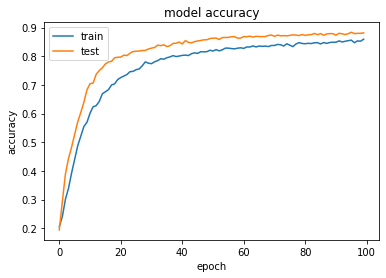

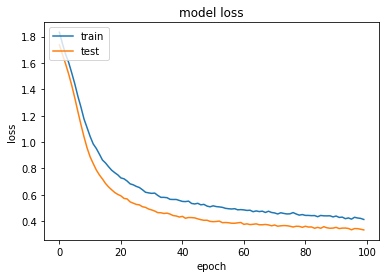

In [ ]:
# Plot the history of the model 
# summarize history for accuracy
plt.plot(historyFT.history['accuracy'])
plt.plot(historyFT.history['val_accuracy'])
plt.title('model accuracy - Fine tuning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historyFT.history['loss'])
plt.plot(historyFT.history['val_loss'])
plt.title('model loss - Fine tuning')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Predict gives scores of the regression, it needs to be turned into the actual class
predicted_classes = modelFT.predict(testgen).argmax(axis=-1)

class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

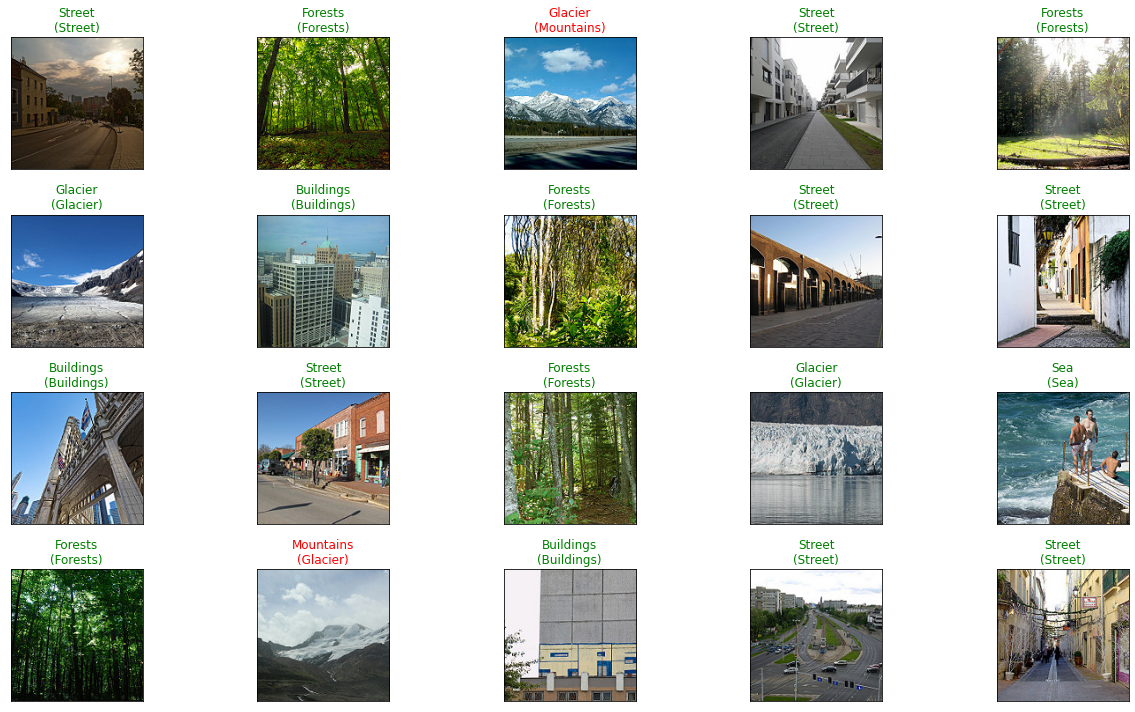

In [ ]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

In [ ]:
results, global_acc = display_results(true_classes, predicted_classes, class_indices.values())
results

Overall Categorical Accuracy: 88.49%


,Precision,Recall,F-Score,Support
1,0.978910,0.989343,0.984099,563.0
5,0.892491,0.907986,0.900172,576.0
0,0.880455,0.911591,0.895753,509.0
4,0.920849,0.865699,0.892423,551.0
3,0.835275,0.821604,0.828383,611.0
2,0.811881,0.824121,0.817955,597.0


### Save FT model

In [ ]:
!ls "$MODELS_PATH"

In [ ]:
f"_acc_{global_acc*100:.2f}_FT".replace(".","_")

'_acc_88_49_FT'

In [ ]:
# Save best model to Google Drive
accuracy_str = f"_acc_{global_acc*100:.2f}_FT".replace(".","_")
model_name = str(datetime.now().strftime("%Y-%m-%d_%H-%M-%S")) + accuracy_str + ".h5"
model_path = MODELS_PATH + "/" + model_name
modelFT.save(model_path)